<a href="https://colab.research.google.com/github/Reichidad/Machine-Learning-2020-Spring-Class/blob/assignment11/assignment11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text classification using neural networks
20145822 김영현


## Decompress movie_review.zip

In [2]:
from zipfile import ZipFile
file_name = "/content/drive/My Drive/Colab Notebooks/data11/movie_review.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Decompress Done')

Decompress Done


## Install CuPy

In [3]:
!pip install cupy-cuda101

## Codes for Data Preprocessing

In [4]:
import numpy as np
import cupy as cp
import re
import nltk
from sklearn.datasets import load_files
nltk.download('stopwords')
nltk.download('wordnet')
import pickle
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split


review_data = load_files(r"movie_review")
X, y = review_data.data, review_data.target

documents = []

stemmer = WordNetLemmatizer()

for sen in range(0, len(X)):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X[sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)

vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(documents).toarray()

tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## Codes for Training & Testing

In [ ]:
num_train = len(X_train)
num_test = len(X_test)

# list for store all iterations
train_loss_list = []
train_accr_list = []
test_loss_list = []
test_accr_list = []

# theta initialization with normal distribution N(0, 1)
theta_u = cp.random.randn(196, 1501)
theta_v = cp.random.randn(49, 197)
theta_w = cp.random.randn(1,50)
# learning values
alpha = 0.01
lambda_reg = 20


# fully connected calculation with bias(1)
def func_calc(theta_list, op_list):
  return cp.matmul(theta_list, op_list)


# sigmoid calculation
def sigmoid(val):
  return 1/(1+cp.exp(-val))


# derivative of the sigmoid
def d_sigmoid(val):
  sig_now = sigmoid(val)
  return sig_now * (1 - sig_now)


# objective function
def ob_func(labels, results, num):
  sum = 0
  for j in range(num):
    sum += (-labels[j] * log_fix(results[j])) - ((1 - labels[j]) * log_fix(1 - results[j]))
  return sum/num + ob_func_reg()


def log_fix(n):
  float_min = 0.0000000000000001
  n[n<float_min] = float_min
  return cp.log(n)


# addition loss with regularization
def ob_func_reg():
  avg_u = cp.mean(theta_u**2)
  avg_v = cp.mean(theta_v**2)
  avg_w = cp.mean(theta_w**2)
  size = theta_u.size + theta_v.size + theta_w.size
  return lambda_reg * (avg_u + avg_v + avg_w) / (2 * size) 


# addition gradient decent with regularization
def g_d_reg(theta):
  size = theta_u.size + theta_v.size + theta_w.size
  return lambda_reg * theta / size


# main function for 1 iteration
def train_once():
  global theta_u, theta_v, theta_w
  # --------------------------
  # training code
  # --------------------------
  # data storage for training
  result_set = cp.empty(num_train)
  y_pred_train = cp.empty(num_train)
  accr = 0
  theta_u_next = cp.zeros((196, 1501))
  theta_v_next = cp.zeros((49, 197))
  theta_w_next = cp.zeros((1, 50))
  
  # training 
  for num in range(num_train):
    # forward-propagation
    x = X_train[num]
    y = func_calc(theta_u, cp.array(np.insert(x, 0, 1)))
    y_sigmoid = sigmoid(y)
    z= func_calc(theta_v, cp.array(np.insert(cp.asnumpy(y_sigmoid), 0, 1)))
    z_sigmoid = sigmoid(z)
    h = func_calc(theta_w, cp.array(np.insert(cp.asnumpy(z_sigmoid), 0, 1)))
    h_sigmoid = sigmoid(h)
    result_set[num] = h_sigmoid[0]

    # accuracy count
    temp_val = 0 if h_sigmoid[0] < 0.5 else 1
    y_pred_train[num] = temp_val 
    if temp_val == y_train[num]:
      accr += 1

    # gradient descent with back-propagation
    d_first = (1-y_train[num])/(1-h_sigmoid) - y_train[num]/h_sigmoid
    theta_w_next += cp.matmul(d_first, cp.array(np.insert(cp.asnumpy(z_sigmoid), 0, 1)).reshape(1,50))
    
    d_second = cp.matmul(d_first, theta_w)
    for i in range(1,50):
      d_second[i] *= d_sigmoid(z[i-1])
    theta_v_next += cp.matmul(d_second[1:].reshape(49, 1), cp.array(np.insert(cp.asnumpy(y_sigmoid), 0, 1)).reshape(1, 197))

    d_third = cp.matmul(d_second[1:50], theta_v)
    for i in range(1,197):
      d_third[i] *= d_sigmoid(y[i-1])
    theta_u_next += cp.matmul(d_third[1:].reshape(196,1), cp.array(np.insert(cp.asnumpy(x), 0, 1)).reshape(1, 1501))

  # store train_loss & train_accuracy after training done
  train_loss = ob_func(y_train, result_set, num_train)
  train_loss_list.append(train_loss)
  accr = accr * 100 / num_train
  train_accr_list.append(accr)

  # --------------------------
  # testing code
  # --------------------------
  # data storage for testing
  test_result_set = cp.empty(num_test)
  y_pred_test = cp.empty(num_test)
  test_accr = 0

  # testing
  for num in range(num_test):
    # forward-propagation only in testing
    x = X_test[num]
    y = func_calc(theta_u, cp.array(np.insert(x, 0, 1)))
    y_sigmoid = sigmoid(y)
    z= func_calc(theta_v, cp.array(np.insert(cp.asnumpy(y_sigmoid), 0, 1)))
    z_sigmoid = sigmoid(z)
    h = func_calc(theta_w, cp.array(np.insert(cp.asnumpy(z_sigmoid), 0, 1)))
    h_sigmoid = sigmoid(h)
    test_result_set[num] = h_sigmoid[0]

    # accuracy count
    temp_val = 0 if h_sigmoid[0] < 0.5 else 1
    y_pred_test[num] = temp_val 
    if temp_val == y_test[num]:
      test_accr += 1
  # store test_loss & test_accuracy after testing done
  test_loss = ob_func(y_test, test_result_set, num_test)
  test_loss_list.append(test_loss)
  test_accr = test_accr * 100 / num_test
  test_accr_list.append(test_accr)

  # update theta
  theta_u -= (alpha * (theta_u_next/num_train + g_d_reg(theta_u)))
  theta_v -= (alpha * (theta_v_next/num_train + g_d_reg(theta_v)))
  theta_w -= (alpha * (theta_w_next/num_train + g_d_reg(theta_w)))

  return y_pred_train, y_pred_test
# start iteration
iteration = 0
limit = 1000
while iteration < limit:
  y_pred_train, y_pred_test = train_once()
  print(iteration)
  print("train / test loss :", train_loss_list[-1], test_loss_list[-1])
  print("train / test accr :", train_accr_list[-1], test_accr_list[-1])
  iteration += 1

## Submissions

### 1. Plot the loss curve

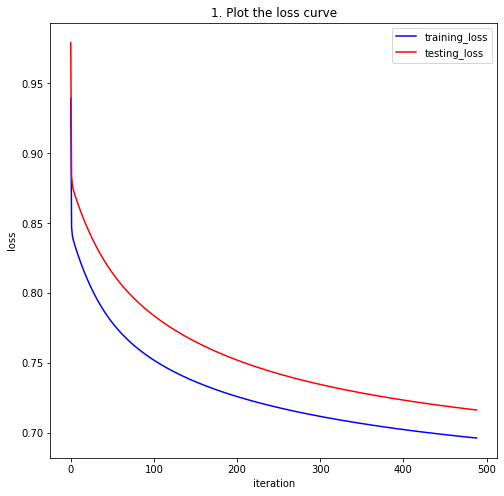

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.title("1. Plot the loss curve")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot([i for i in range(iteration)], train_loss_list, label="training_loss", c='b')
plt.plot([i for i in range(iteration)], test_loss_list, label="testing_loss", c='r')
plt.legend()
plt.show()

### 2. Plot the accuracy curve

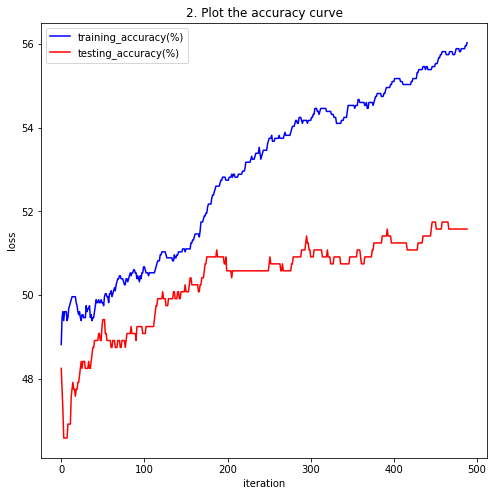

In [21]:
plt.figure(figsize=(8,8))
plt.title("2. Plot the accuracy curve")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot([i for i in range(iteration)], train_accr_list, label="training_accuracy(%)", c='b')
plt.plot([i for i in range(iteration)], test_accr_list, label="testing_accuracy(%)", c='r')
plt.legend()
plt.show()

### 3. Plot the quantitative results

In [25]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
y_pred_train = cp.asnumpy(y_pred_train)
y_pred_test = cp.asnumpy(y_pred_test)
print(confusion_matrix(y_train,y_pred_train))
print(classification_report(y_train,y_pred_train))
print(accuracy_score(y_train, y_pred_train))

print(confusion_matrix(y_test,y_pred_test))
print(classification_report(y_test,y_pred_test))
print(accuracy_score(y_test, y_pred_test))


[[390 309]
 [307 395]]
              precision    recall  f1-score   support

           0       0.56      0.56      0.56       699
           1       0.56      0.56      0.56       702

    accuracy                           0.56      1401
   macro avg       0.56      0.56      0.56      1401
weighted avg       0.56      0.56      0.56      1401

0.5603140613847252
[[154 148]
 [143 156]]
              precision    recall  f1-score   support

           0       0.52      0.51      0.51       302
           1       0.51      0.52      0.52       299

    accuracy                           0.52       601
   macro avg       0.52      0.52      0.52       601
weighted avg       0.52      0.52      0.52       601

0.5158069883527454


### 4. Testing accuracy

In [27]:
print("Testing accuracy :", test_accr_list[-1], "%")

Testing accuracy : 51.58069883527454 %
